In [1]:
import pandas as pd
from pathlib import Path
import torch
import sys
sys.path.append('src')

# from models.ae_kan import KANAutoencoder
from src.utils.new_preprocessing import preprocessing_dataset, simple_train_kan, change_hyperparam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"Memory available: {torch.cuda.mem_get_info()[0] / 1024**3:.1f} GB")

print(f"Device : {device}")

GPU: NVIDIA GeForce RTX 3070 Laptop GPU
Total memory: 8.0 GB
Memory available: 6.9 GB
Device : cuda


In [2]:
data_dir = Path("data/processed/sectors")
sectors_list = [d.name for d in data_dir.iterdir() if d.is_dir() and d.name != 'unknown']

sector_log_returns = {}
for sector in sectors_list:
    returns_path = data_dir / sector / "log_returns.csv"
    df = pd.read_csv(returns_path, index_col=0)
    sector_log_returns[sector] = df.iloc[1:]  # Skip first row with NaN values

In [3]:
X_df = {}
W_df = {}
M_df = {}
data = {}

for sector in sector_log_returns:
    # Preprocess data for each sector
    X_df[sector], W_df[sector], M_df[sector] = preprocessing_dataset(
        log_returns_df=sector_log_returns[sector],
        win=60,
        min_periods=40,
        clip_val=3.0,
        min_valid_per_day=5,
        use_median=True,
        soft_weights=True
    )
    
    # Create tensors for each sector
    tensors = {
        'X': torch.tensor(X_df[sector].values, dtype=torch.float32),
        'W': torch.tensor(W_df[sector].values, dtype=torch.float32),
        'M': torch.tensor(M_df[sector].values, dtype=torch.float32)
    }

    # Split into train/test for each sector
    train_size = int(0.8 * len(tensors['X']))
    data[sector] = {
        'train': {
            'X': tensors['X'][:train_size],
            'W': tensors['W'][:train_size],
            'M': tensors['M'][:train_size]
        },
        'test': {
            'X': tensors['X'][train_size:],
            'W': tensors['W'][train_size:],
            'M': tensors['M'][train_size:]
        }
    }

print(f"\nSector: {sector}")
print(f"Train: {data[sector]['train']['X'].shape[0]} échantillons")
print(f"Test: {data[sector]['test']['X'].shape[0]} échantillons") 
print(f"Dates train: {X_df[sector].index[0]} à {X_df[sector].index[train_size-1]}")
print(f"Dates test: {X_df[sector].index[train_size]} à {X_df[sector].index[-1]}")


Sector: utilities
Train: 2987 échantillons
Test: 747 échantillons
Dates train: 2010-03-03 à 2022-01-10
Dates test: 2022-01-11 à 2024-12-31


In [4]:
log_returns_df = pd.read_csv("data/processed/dataset_log_returns.csv", index_col=0)
log_returns_df = log_returns_df.iloc[1:]

In [7]:
sp500_X_df, sp500_W_df, sp500_M_df = preprocessing_dataset(
    log_returns_df=log_returns_df,  # Utilise tous les returns
    win=60,
    min_periods=40, 
    clip_val=3.0,
    min_valid_per_day=5,
    use_median=True,
    soft_weights=True
)

sp500_tensors = {
    'X': torch.tensor(sp500_X_df.values, dtype=torch.float32),
    'W': torch.tensor(sp500_W_df.values, dtype=torch.float32), 
    'M': torch.tensor(sp500_M_df.values, dtype=torch.float32)
}

# Split train/test
train_size = int(0.8 * len(sp500_tensors['X']))
full_data = {
    'train': {
        'X': sp500_tensors['X'][:train_size],
        'W': sp500_tensors['W'][:train_size],
        'M': sp500_tensors['M'][:train_size]
    },
    'test': {
        'X': sp500_tensors['X'][train_size:],
        'W': sp500_tensors['W'][train_size:],
        'M': sp500_tensors['M'][train_size:]
    }
}

In [8]:
full_data["train"]["X"]
data["utilities"]["train"]["X"]

tensor([[ 0.7095, -0.2273,  1.4788,  ...,  0.6971, -0.0319,  0.1895],
        [ 0.5891, -0.2844, -0.7470,  ..., -0.0982, -0.4259, -0.9280],
        [ 0.3553,  0.0000,  0.2215,  ...,  0.7744, -0.5840, -0.4092],
        ...,
        [-0.0682,  0.0000,  0.2831,  ...,  0.9535, -0.1712, -0.3092],
        [-0.2909,  1.1647, -0.8697,  ...,  0.6001,  0.0765,  0.1190],
        [-0.4511, -0.1024,  0.0603,  ..., -0.0457,  0.0000,  1.2413]])

In [30]:
# I will create feature engineering for the SP500 dataset (lags, moving average, ...)

# Training

In [9]:
from src.utils.new_preprocessing import hyperparameter_comparison

sector = "financials"

hyperparams = {
    'hidden_dims_choices': [128, 64],
    'latent_dims': 16,
    
    # BASIS
    'basis_types': 'spline',
    'M_values': 16,
    'poly_degrees': 3,
    'use_silu_choices': True,
    'dropout_rates': 0,
    
    # SKIP LINEAIRE
    'use_global_skip': True,
    'use_skip_choices': False,
    'skip_init_choices': 'identity',
    'skip_gain_values': 0.1,
    'max_skip_gain': 0.3,
    
    # REGULARISATION
    'lambda_alpha_values': 1e-4,
    'lambda_group_values': 1e-4,
    'lambda_tv_values': 1e-5,
    'lambda_poly_decay_values': 1e-6,
    'lambda_skip_l2_values': 1e-3,
    'lambda_reg_values': 1e-5,
    
    # LOSS
    'loss_types': 'huber',
    'huber_deltas': 1.0,
    
    # OPTIMISATION
    'batch_sizes': 128,
    'learning_rates': 0.0002,
    'weight_decays': 0.000001
}

In [10]:
from src.models.ae_kan import KANAutoencoder
from src.models.gated_kan_ae import GatedKANAutoencoder


sector = "financials"
input_dim = full_data["train"]["X"].shape[1]

kan_gated = GatedKANAutoencoder(
    input_dim=input_dim,
    k=hyperparams['latent_dims'],
    hidden_dims=hyperparams['hidden_dims_choices'],
    
    # BASIS
    basis_type=hyperparams['basis_types'],
    M=hyperparams['M_values'],
    poly_degree=hyperparams['poly_degrees'],
    use_silu=hyperparams['use_silu_choices'],
    dropout_p=hyperparams['dropout_rates'],
    
    # SKIP GATED
    gate_init=0.5,
    skip_rank=None, # Rang du skip automatique
    
    # REGULARISATION
    lambda_alpha=hyperparams['lambda_alpha_values'],
    lambda_group=hyperparams['lambda_group_values'], 
    lambda_tv=hyperparams['lambda_tv_values'],
    lambda_orthogonal=hyperparams['lambda_skip_l2_values'],
    lambda_gate_reg=hyperparams['lambda_reg_values'],
    
    # LOSS
    loss_type=hyperparams['loss_types'],
    huber_delta=hyperparams['huber_deltas']
).to(device)

kan_gated.print_architecture_info()

🚪 Gated KAN Autoencoder - Input: 423, Latent: 16
   📐 Hidden dims: [128, 64]
   🎛️  Gate: KAN=0.500 | Skip=0.500
   📊 Skip rank: 64
   🔧 Orthogonality λ: 1.00e-03


In [11]:
history_gated = kan_gated.fit(
    X=full_data["train"]["X"],
    batch_size=hyperparams["batch_sizes"],
    learning_rate=hyperparams["learning_rates"],
    weight_decay=hyperparams["weight_decays"],
    epochs=30,
    patience=10,
    verbose=True
)

📈 Epoch 1/30 | Train: 0.960321 | Val: 0.252496 ❌
   ↳ Recon: 0.261920 | Reg: 0.698400 | Orth: 0.000643 🔀
   🎛️  Gate: 0.261 (KAN: 26.1%, Skip: 73.9%) | Orth_viol: 0.0199
📈 Epoch 2/30 | Train: 0.704465 | Val: 0.237832 ✅
   ↳ Recon: 0.244826 | Reg: 0.459638 | Orth: 0.000424 🔀
   🎛️  Gate: 0.263 (KAN: 26.3%, Skip: 73.7%) | Orth_viol: 0.0169
📈 Epoch 3/30 | Train: 0.495755 | Val: 0.225225 ✅
   ↳ Recon: 0.229631 | Reg: 0.266123 | Orth: 0.000626 🔀
   🎛️  Gate: 0.253 (KAN: 25.3%, Skip: 74.7%) | Orth_viol: 0.0211
📈 Epoch 4/30 | Train: 0.361967 | Val: 0.215696 ✅
   ↳ Recon: 0.217724 | Reg: 0.144242 | Orth: 0.000903 🔀
   🎛️  Gate: 0.235 (KAN: 23.5%, Skip: 76.5%) | Orth_viol: 0.0250
📈 Epoch 5/30 | Train: 0.274715 | Val: 0.208389 ✅
   ↳ Recon: 0.208461 | Reg: 0.066253 | Orth: 0.001132 🔀
   🎛️  Gate: 0.217 (KAN: 21.7%, Skip: 78.3%) | Orth_viol: 0.0280
📈 Epoch 6/30 | Train: 0.228334 | Val: 0.202411 ✅
   ↳ Recon: 0.201176 | Reg: 0.027157 | Orth: 0.001246 🔀
   🎛️  Gate: 0.198 (KAN: 19.8%, Skip: 80.2%) 

c:\Users\xtrem\Documents\Git\DimRed-KAN-Finance\src\models\gated_kan_ae.py:771: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


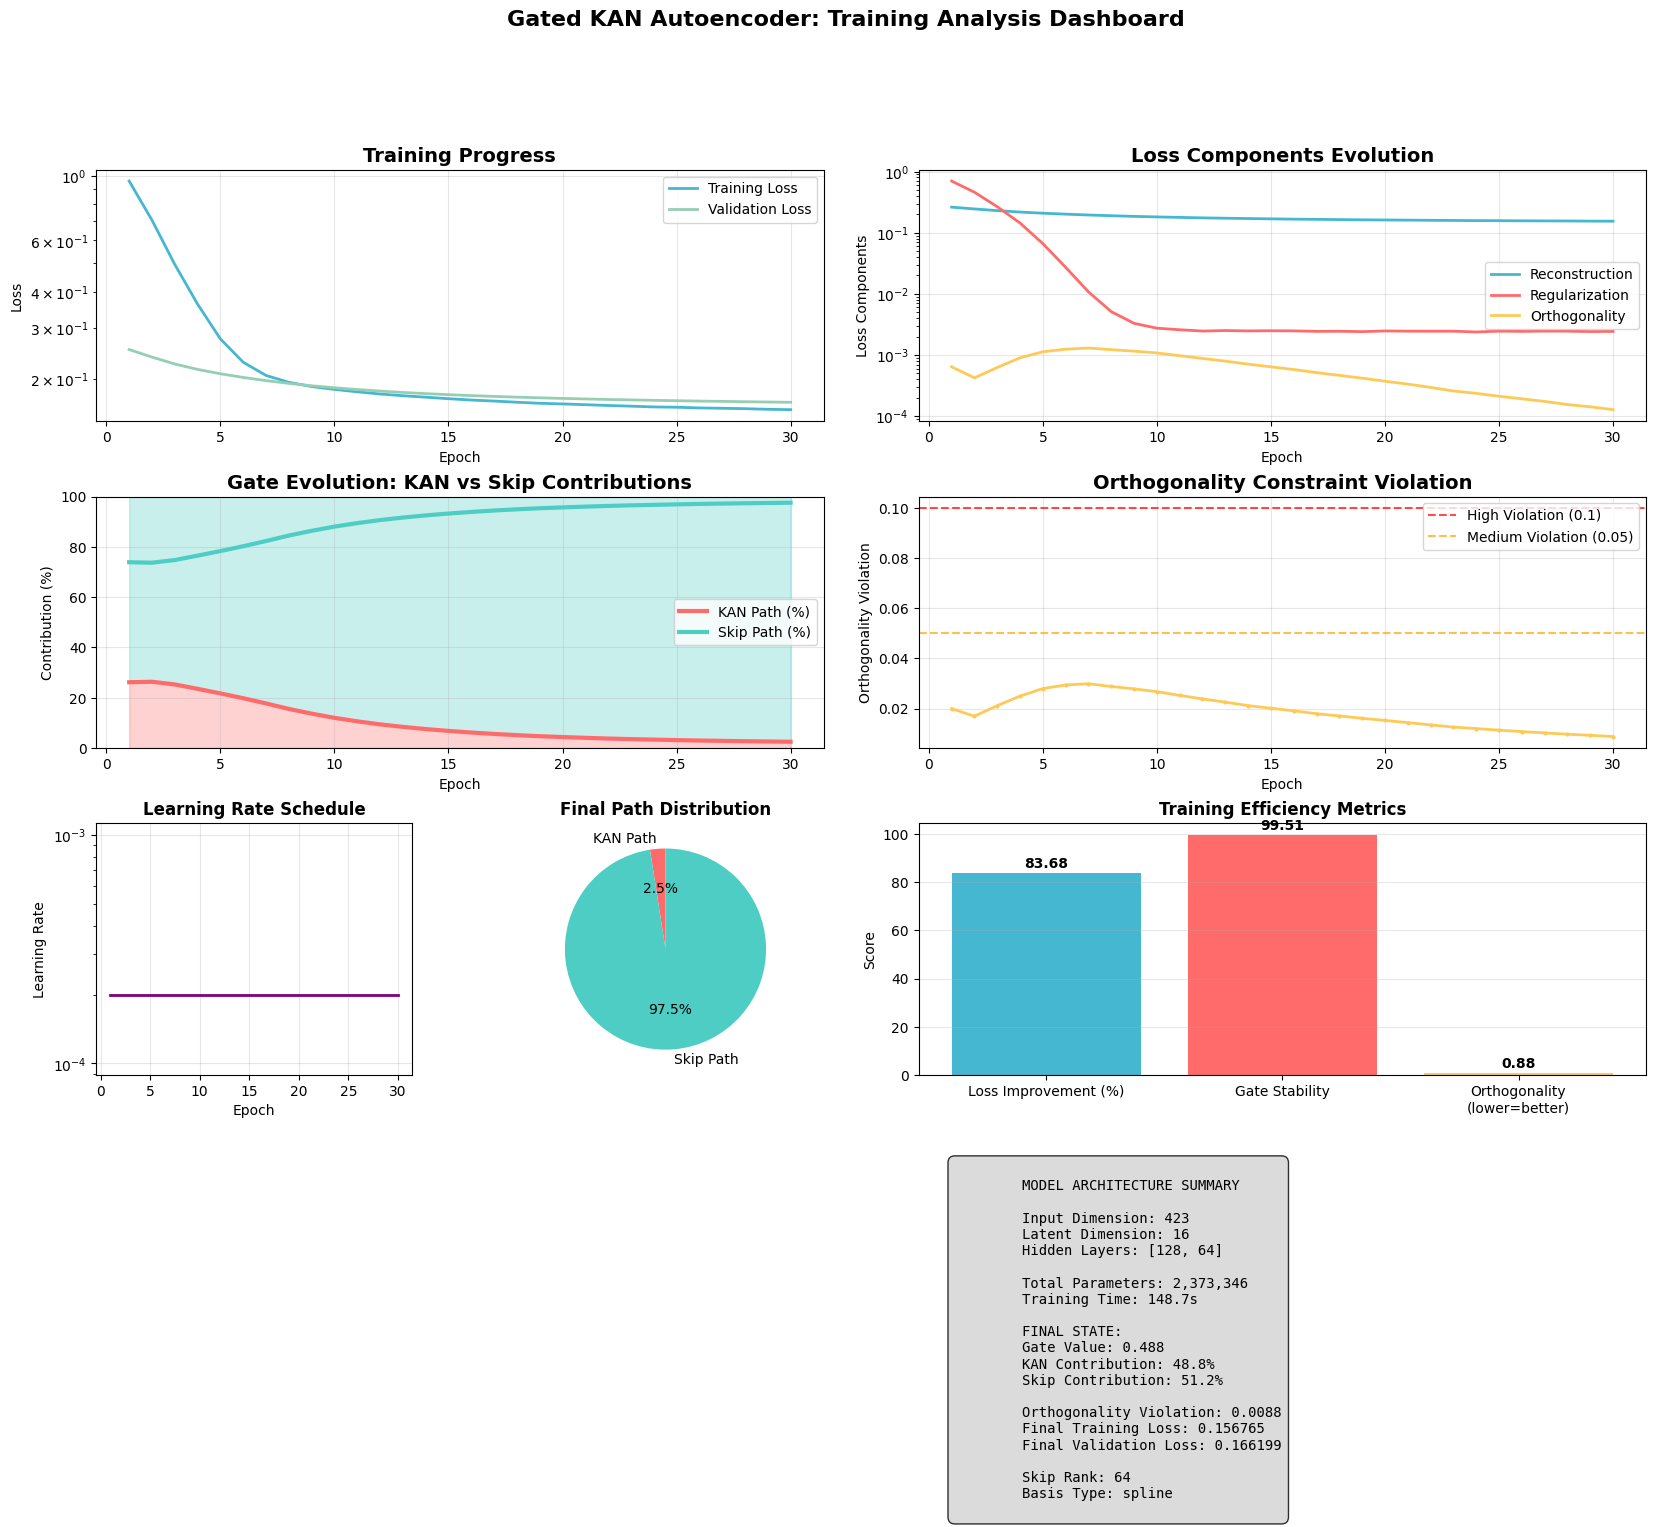


🚪 GATED KAN AUTOENCODER - TRAINING SUMMARY
📈 Loss Improvement: 83.68%
🎛️  Final Gate: KAN=48.8% | Skip=51.2%
🔀 Orthogonality Violation: 0.0088
⏱️  Training Time: 148.7s
🎯 Best Validation Loss: 0.166199


In [12]:
kan_gated.plot_training_analysis(history_gated)

In [17]:
latent = kan_gated.get_latent_representation(full_data["test"]["X"])

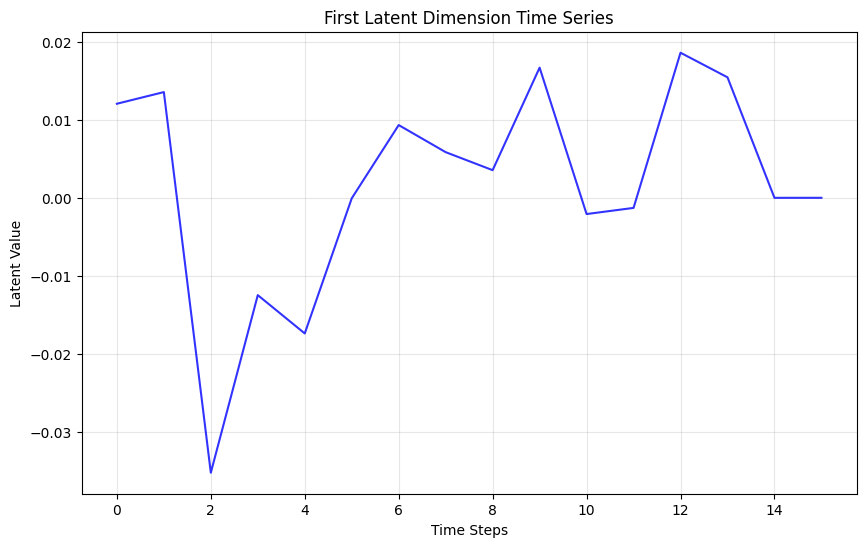

In [27]:
import matplotlib.pyplot as plt

# Convert tensor to numpy array properly
latent_np = latent.cpu().numpy()

# Plot first latent dimension
plt.figure(figsize=(10, 6))
plt.plot(latent_np[200], color='blue', alpha=0.8)
plt.title('First Latent Dimension Time Series')
plt.xlabel('Time Steps') 
plt.ylabel('Latent Value')
plt.grid(True, alpha=0.3)